#### Library importation

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from mlxtend.frequent_patterns import association_rules
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from sklearn.decomposition import PCA
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [18]:
#Read the dataset into dataframe
df =pd.read_excel("mhs.xls")

In [19]:
# Check Random 3 samples
df.sample(3)

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
63     29          90           70   6.7      98.0         80   mid risk
962    32         140           90  18.0      98.0         88  high risk
1002   55         140           95  19.0      98.0         77  high risk

#### Check the data type
The datatypes of the data are fine

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


### check the description of the data

In [21]:
df.describe()

Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  
50%      76.000000  
75%      80.000000  
max      90.000000

### Checking for outliers

Body temperature
Research has shoun that the possible range of temperature in fahrenheit during pregnancy is between 97.5F and 99.5F and at its lowest it can drop to between 95.5F and 99.1F(Crna, 2023), it is not uncommon for body temperature to rise during pregnancy but when it is above 100.4F, it is considered abnormal. (Crna, 2023). In our date, the maximum temperature is 103F which is not impossible but it can only increase the risk of the mother and the risk(Friel, 2023).Therefore no record is dropped for temperature column.

Heartbeat.
The range of heartbeat in the data is between 7 and 90 and only two record had 7 which is considered an outlier. this records will not be dropped, we will use Mediam imputation for them. 


###### decribe the  values for the Temperature

In [22]:

df[df['BodyTemp']>100.4].describe()

Age  SystolicBP  DiastolicBP          BS    BodyTemp   HeartRate
count  177.000000  177.000000   177.000000  177.000000  177.000000  177.000000
mean    22.966102  102.039548    68.915254    8.102260  101.519774   76.627119
std     10.878930   17.183291    10.964750    1.928523    0.631470    7.435858
min     12.000000   83.000000    60.000000    6.000000  101.000000   60.000000
25%     17.000000   90.000000    60.000000    6.900000  101.000000   70.000000
50%     17.000000   90.000000    65.000000    7.500000  101.000000   76.000000
75%     28.000000  120.000000    80.000000    9.000000  102.000000   86.000000
max     70.000000  140.000000   100.000000   18.000000  103.000000   86.000000

In [23]:
#find the abnormal heartrate
df[df['HeartRate']<50]

Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
499   16         120           75  7.9      98.0          7  low risk
908   16         120           75  7.9      98.0          7  low risk

#### Perform Median imputation for Age < 50

In [24]:
# Calculate the median age
median_heartrate = np.median(df['HeartRate'])

# Replace age values less than 10 with the median age
df.loc[df['HeartRate'] == 7, 'HeartRate'] = median_heartrate


### Find missing values

In [25]:
print(df.isna().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


### Check for duplicates
Ther is no unique id so we will not find duplicates
In a dataset where there are multiple readings for the same patient, it is not appropriate to check for duplicates based on the entire row as it is expected that the readings will differ across rows for the same patient. Instead, you would need to check for duplicates based on a unique patient identifier, such as a patient ID, to ensure that each row represents a unique patient observation.

In [26]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
print(f"Total length of the dataframe rows: {len(df)}")

Number of duplicate rows: 562
Total length of the dataframe rows: 1014


#### Group the datasets based on age in to 6 groups

In [36]:
df['Age_designation'] = df['Age'].apply(lambda x: 'Children' if x <= 12 else 
                                        ('Adolescents' if x <= 17 else 
                                         ('Pre-menopausal Adults' if x <= 44 
                                          else ('Menopausal Adults' if x <= 55 
                                                else ('Post-menopausal Adults' if x <= 64 else 'Older adults')))))
age_df = df.groupby('Age_designation').agg(age_count=('Age_designation', 'count'),
                                           percentage=('Age_designation', lambda x: round((x.count() / len(df)) * 100, 1)))

age_df

age_count  percentage
Age_designation                              
Adolescents                   154        15.2
Children                       39         3.8
Menopausal Adults             138        13.6
Older adults                    5         0.5
Post-menopausal Adults         40         3.9
Pre-menopausal Adults         638        62.9

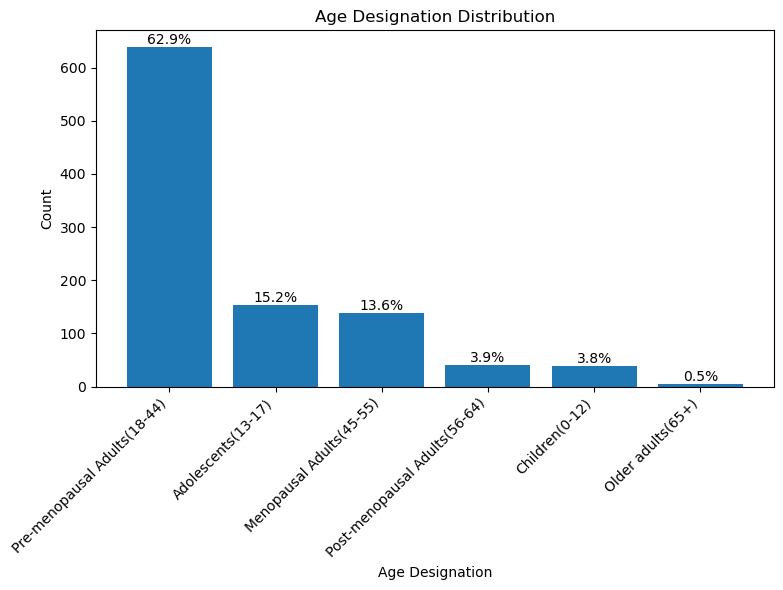

In [28]:

# Create the data
age_designation = ['Adolescents(13-17)', 'Children(0-12)', 'Menopausal Adults(45-55)', 'Older adults(65+)', 'Post-menopausal Adults(56-64)', 'Pre-menopausal Adults(18-44)']
age_count = [154, 39, 138, 5, 40, 638]
percentage = [15.2, 3.8, 13.6, 0.5, 3.9, 62.9]

# Sort the data in descending order
sorted_data = sorted(zip(age_designation, age_count, percentage), key=lambda x: x[1], reverse=True)
age_designation, age_count, percentage = zip(*sorted_data)

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(age_designation, age_count)
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.xlabel('Age Designation')
plt.ylabel('Count')
plt.title('Age Designation Distribution')

# Add the percentage labels to the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage[i]}%', ha='center', va='bottom')

plt.tight_layout()  # Prevents labels from getting cut off
plt.show()


#### Plot the scatter plot to see relationshipss between variaes

In [29]:
sns.pairplot(data=df[['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate','RiskLevel']], hue='RiskLevel')
plt.show()


### Encode the Risk Levels

In [30]:
y = df['RiskLevel']

print("===========Smaple Y===============")
print(y.sample(2))
print(f"Length of y is : {len(y)}")
print("==============================")
print(f"Length of  scaled Data is  : {len(df_scaled)}")

===========Smaple Y===============
672     low risk
171    high risk
Name: RiskLevel, dtype: object
Length of y is : 1014


NameError: name 'df_scaled' is not defined

### Cheking Unique values for y

In [ ]:
unique_values = pd.DataFrame({'y': y})
unique_values['y'].unique()

### Convert to Integer labelds for easy analysis
'low risk' -------->  1 <br>
'mid risk' ---------> 2 <br>
'high risk' ------>   3 <br>

In [42]:
risk_mapping = {'low risk': 1, 'mid risk': 2, 'high risk': 3}

# Map the risk levels using the mapping dictionary
df['RiskLevel'] = df['RiskLevel'].map(risk_mapping)

# Print the resulting dataframe
print(df.head(5))


   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0   25         130           80  15.0      98.0         86          3   
1   35         140           90  13.0      98.0         70          3   
2   29          90           70   8.0     100.0         80          3   
3   30         140           85   7.0      98.0         70          3   
4   35         120           60   6.1      98.0         76          1   

         Age_designation  
0  Pre-menopausal Adults  
1  Pre-menopausal Adults  
2  Pre-menopausal Adults  
3  Pre-menopausal Adults  
4  Pre-menopausal Adults  


### setting the value for y

In [43]:
y = df['SystolicBP']
y.sample(2)

432    140
941    120
Name: SystolicBP, dtype: int64

In [44]:
df.sample(4)

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
184   60         120           80   6.1      98.0         75          1   
537   19         120           75   7.5      98.0         66          1   
91    60         120           85  15.0      98.0         60          2   
471   42         140          100  18.0      98.0         90          3   

            Age_designation  
184  Post-menopausal Adults  
537   Pre-menopausal Adults  
91   Post-menopausal Adults  
471   Pre-menopausal Adults

In [45]:
df

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0      25         130           80  15.0      98.0         86          3   
1      35         140           90  13.0      98.0         70          3   
2      29          90           70   8.0     100.0         80          3   
3      30         140           85   7.0      98.0         70          3   
4      35         120           60   6.1      98.0         76          1   
...   ...         ...          ...   ...       ...        ...        ...   
1009   22         120           60  15.0      98.0         80          3   
1010   55         120           90  18.0      98.0         60          3   
1011   35          85           60  19.0      98.0         86          3   
1012   43         120           90  18.0      98.0         70          3   
1013   32         120           65   6.0     101.0         76          2   

            Age_designation  
0     Pre-menopausal Adults  
1     Pre-menopausal Adults  
2     Pre-menopausal Adults  
3     Pre-menopausal Adults  
4     Pre-menopausal Adults  
...                     ...  
1009  Pre-menopausal Adults  
1010      Menopausal Adults  
1011  Pre-menopausal Adults  
1012  Pre-menopausal Adults  
1013  Pre-menopausal Adults  

[1014 rows x 8 columns]

### Visualizing the distribution of each variable using histogram and box plot
In the UK, it is rare for women to become pregnant naturally after the age of 50, as the menopause typically occurs between the ages of 45 and 55. However, it is possible for women to become pregnant with the help of assisted reproductive technologies such as IVF, even after the age of 50. so this has to be factored in. In the UK, the age at which pregnancy can no longer occur naturally is around 51 years old, which is the age at which menopause typically occurs. However, with the use of assisted reproductive technologies such as in vitro fertilization (IVF), pregnancy may be possible beyond this age, although the success rates of IVF decrease significantly after age 40. It is important to note that every woman is different, and the age at which menopause occurs can vary.

It is not always appropriate to remove all outliers caught by a box plot or any other outlier detection method. The decision to remove outliers should be based on the context and nature of the data, as well as the objectives of the analysis. Outliers can be legitimate data points that provide valuable insights or indicate a rare event. Removing them without a valid reason can lead to biased and unreliable results.

However, if the outliers are deemed to be erroneous or data entry errors, then they can be removed. It is important to document the reason for removing outliers and the impact it may have on the analysis. Additionally, the impact of outlier removal should be assessed by performing sensitivity analysis or comparing the results with and without outliers.

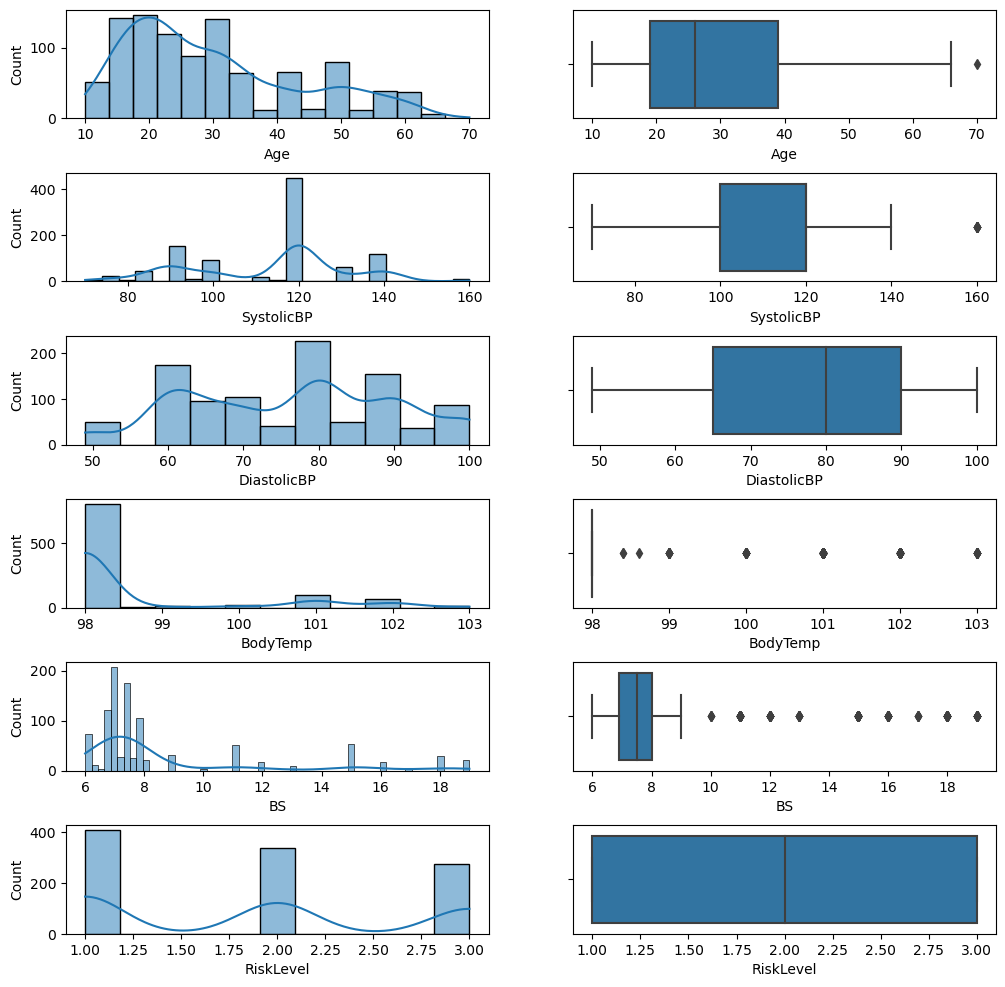

In [47]:
fig, axs = plt.subplots(6, 2, figsize=(12, 12))
sns.histplot(x='Age', data=df, kde=True, ax=axs[0, 0])
sns.boxplot(x='Age', data=df, ax=axs[0, 1])
sns.histplot(x='SystolicBP', data=df, kde=True, ax=axs[1, 0])
sns.boxplot(x='SystolicBP', data=df, ax=axs[1, 1])
sns.histplot(x='DiastolicBP', data=df, kde=True, ax=axs[2, 0])
sns.boxplot(x='DiastolicBP', data=df, ax=axs[2, 1])
sns.histplot(x='BodyTemp', data=df, kde=True, ax=axs[3, 0])
sns.boxplot(x='BodyTemp', data=df, ax=axs[3, 1])
sns.histplot(x='BS', data=df, kde=True, ax=axs[4, 0])
sns.boxplot(x='BS', data=df, ax=axs[4, 1])
sns.histplot(x='RiskLevel', data=df, kde=True, ax=axs[5, 0])
sns.boxplot(x='RiskLevel', data=df, ax=axs[5, 1])
fig.subplots_adjust(hspace=0.5)
plt.show()

### Check for correlation

The Diastolic Bp,Age and Bs all have a good correlation with the SystolicBP
In order to predict SystolicBP, we need to analyze the correlation of SystolicBP with other variables and choose the ones that are most strongly correlated with it.

From the given correlation matrix, we can see that the variables most strongly correlated with SystolicBP are DiastolicBP (0.787), Age (0.416), and BS (0.425). BodyTemp and HeartRate have weak correlation coefficients with SystolicBP.

Therefore, we should keep DiastolicBP, Age, and BS as predictor variables and drop BodyTemp and HeartRate in order to predict SystolicBP.

Additionally, we can also see that there is a positive correlation between Age and BS (0.473) and a negative correlation between Age and BodyTemp (-0.255), which suggests that older women tend to have higher blood sugar levels and lower body temperatures. This information can be useful for further analysis and understanding of the data.

In [48]:
# calculate the correlation
corr_matrix = df.corr() * 100
#round it up to 2 decimal places
corr_matrix = corr_matrix.round(2)
#print the matrix
print(corr_matrix)

                Age  SystolicBP  DiastolicBP      BS  BodyTemp  HeartRate  \
Age          100.00       41.60        39.80   47.33    -25.53       6.72   
SystolicBP    41.60      100.00        78.70   42.52    -28.66      -1.82   
DiastolicBP   39.80       78.70       100.00   42.38    -25.75      -5.16   
BS            47.33       42.52        42.38  100.00    -10.35      14.92   
BodyTemp     -25.53      -28.66       -25.75  -10.35    100.00       9.75   
HeartRate      6.72       -1.82        -5.16   14.92      9.75     100.00   
RiskLevel     26.72       39.65        34.66   56.99     16.40      18.97   

             RiskLevel  
Age              26.72  
SystolicBP       39.65  
DiastolicBP      34.66  
BS               56.99  
BodyTemp         16.40  
HeartRate        18.97  
RiskLevel       100.00  


C:\Users\OWNER\AppData\Local\Temp\ipykernel_28264\1808480052.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr() * 100


#### ploting the correlation matrix

C:\Users\OWNER\AppData\Local\Temp\ipykernel_28264\625742099.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


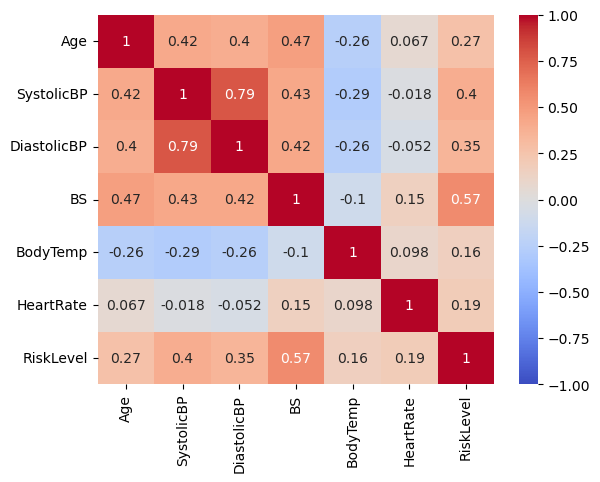

In [49]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.show()

### Test for Collinearity using Variance inflation factor

In [50]:
# calculate the variance inflation factors (VIF) for each predictor variable
X = np.array([
    corr_matrix['Age'],
    corr_matrix['DiastolicBP'],
    corr_matrix['BS'],
    corr_matrix['BodyTemp'],
    corr_matrix['HeartRate'],
    corr_matrix['RiskLevel']
]).T
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# print the VIFs for each predictor variable
print('Variance Inflation Factors (VIFs):')
print(pd.Series(vif, index=['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']))

X = np.hstack((np.ones((X.shape[0], 1)), X))
vif = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]


Variance Inflation Factors (VIFs):
Age            4.119848
DiastolicBP    4.286872
BS             8.594594
BodyTemp       2.412073
HeartRate      1.304953
RiskLevel      6.895404
dtype: float64


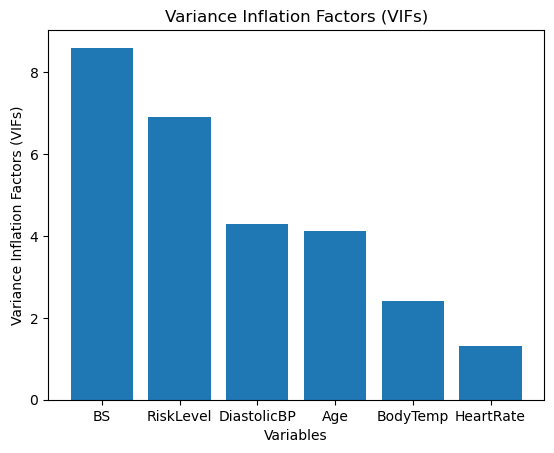

In [51]:
# create a dictionary of value-pairs
data = {'Age': 4.119848, 'DiastolicBP': 4.286872, 'BS': 8.594594, 'BodyTemp': 2.412073, 'HeartRate': 1.304953, 'RiskLevel': 6.895404}
# convert the dictionary to a pandas dataframe
df_ = pd.DataFrame.from_dict(data, orient='index', columns=['VIF'])
# sort the dataframe by the 'VIF' column in descending order
sorted_df = df_.sort_values(by='VIF', ascending=False)
# create a bar chart from the sorted dataframe
plt.bar(sorted_df.index, sorted_df['VIF'])
# set the x-axis label
plt.xlabel('Variables')
# set the y-axis label
plt.ylabel('Variance Inflation Factors (VIFs)')
# set the title of the chart
plt.title('Variance Inflation Factors (VIFs)')
# show the chart
plt.show()

#### Plotting the Correlation and VIF side by side
Diastoli,Age and BS are good.

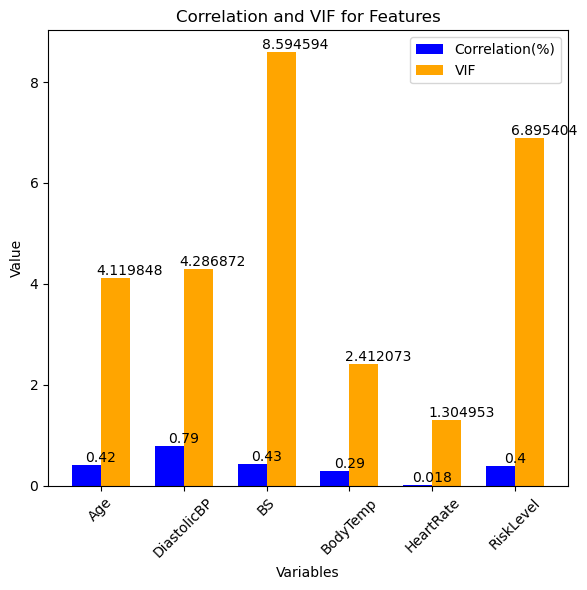

In [52]:

variables = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']
correlation_values = [0.42, 0.79, 0.43, 0.29, 0.018, 0.4]
vif_values = [4.119848, 4.286872, 8.594594, 2.412073, 1.304953, 6.895404]

fig, ax = plt.subplots(figsize=(6, 6))
index = np.arange(len(variables))
bar_width = 0.35

correlation_bar = ax.bar(index, correlation_values, bar_width, color='blue', label='Correlation(%)')
vif_bar = ax.bar(index + bar_width, vif_values, bar_width, color='orange', label='VIF')

ax.set_xlabel('Variables')
ax.set_ylabel('Value')
ax.set_title('Correlation and VIF for Features')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(variables, rotation=45)
ax.legend()

# Labeling the bars with corresponding values
for i in range(len(variables)):
    ax.text(index[i] + bar_width / 2, correlation_values[i], str(correlation_values[i]), ha='center', va='bottom')
    ax.text(index[i] + bar_width * 1.5, vif_values[i], str(vif_values[i]), ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Scaling all the variables that may be used for the analysis

In [54]:
### Copy df 
df1 = df.copy()

In [55]:
# create a scaler object
scaler = StandardScaler()

# fit and transform the data
df_scaled = scaler.fit_transform(df1[['Age', 'DiastolicBP', 'BS', 'BodyTemp','RiskLevel']])

#convert back to dataframe
df_scaled = pd.DataFrame(df_scaled, columns=['Age', 'DiastolicBP', 'BS', 'BodyTemp','RiskLevel'])


In [56]:
df_scaled.sample(2)

Age  DiastolicBP        BS  BodyTemp  RiskLevel
147 -1.104253    -0.825751 -0.615444 -0.485215  -1.075464
549  1.791556     1.696054  1.905890 -0.485215   1.402991

#### Confirm the lenght of the Features and label

In [57]:
df

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0      25         130           80  15.0      98.0         86          3   
1      35         140           90  13.0      98.0         70          3   
2      29          90           70   8.0     100.0         80          3   
3      30         140           85   7.0      98.0         70          3   
4      35         120           60   6.1      98.0         76          1   
...   ...         ...          ...   ...       ...        ...        ...   
1009   22         120           60  15.0      98.0         80          3   
1010   55         120           90  18.0      98.0         60          3   
1011   35          85           60  19.0      98.0         86          3   
1012   43         120           90  18.0      98.0         70          3   
1013   32         120           65   6.0     101.0         76          2   

            Age_designation  
0     Pre-menopausal Adults  
1     Pre-menopausal Adults  
2     Pre-menopausal Adults  
3     Pre-menopausal Adults  
4     Pre-menopausal Adults  
...                     ...  
1009  Pre-menopausal Adults  
1010      Menopausal Adults  
1011  Pre-menopausal Adults  
1012  Pre-menopausal Adults  
1013  Pre-menopausal Adults  

[1014 rows x 8 columns]

## Question 1: Linear Regression

## Ascertaining the best possible choice of Features

### The choices we want to check
1. Age, DiastolicBP, BS, and BodyTemp<br>
2. Age and BS<br>
3. Age DiastolicBP, bodyTemp<br>
4. DiastolicBP, BS and Age<br>
5. Age, DiastolicBP, BS, and Risk Level
6. Age, DiastolicBP

In [58]:
y_sys = df['SystolicBP']
y_sys.sample(2)

424    120
411     90
Name: SystolicBP, dtype: int64

In [59]:


# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_sys, test_size=0.2, random_state=20)
#####X1_train = X_train[['Age', 'DiastolicBP', 'RiskLevel', 'BodyTemp']] ### Gbenga


X1_train = X_train[['Age', 'DiastolicBP', 'BS', 'BodyTemp']]
X1_test = X_test[['Age', 'DiastolicBP', 'BS', 'BodyTemp']]

X2_train = X_train[['Age', 'BS']]
X2_test = X_test[['Age', 'BS']]

X3_train = X_train[['Age', 'DiastolicBP', 'BodyTemp']]
X3_test = X_test[['Age', 'DiastolicBP', 'BodyTemp']]

X4_train = X_train[['DiastolicBP','BS', 'Age']]
X4_test = X_test[['DiastolicBP','BS', 'Age']]

X5_train = X_train[['Age','DiastolicBP', 'BS','RiskLevel']]
X5_test = X_test[['Age','DiastolicBP', 'BS','RiskLevel']]


X6_train = X_train[['Age','DiastolicBP']]
X6_test = X_test[['Age','DiastolicBP']]


# X5_train = X_train[['Age', 'BS','RiskLevel']]
# X5_test = X_test[['Age', 'BS','RiskLevel']]

# perform linear regression on X1
lr_X1 = LinearRegression()
lr_X1.fit(X1_train, y_train)
y_pred_X1 = lr_X1.predict(X1_test)
mse_X1 = mean_squared_error(y_test, y_pred_X1)
r2_X1 = r2_score(y_test, y_pred_X1)
print("MSE of X1:", mse_X1)
print("R-Score of X1:", r2_X1)
r_squared = lr_X1.score(X1_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)

# perform linear regression on X2
lr_X2 = LinearRegression()
lr_X2.fit(X2_train, y_train)
y_pred_X2 = lr_X2.predict(X2_test)
mse_X2 = mean_squared_error(y_test, y_pred_X2)
print("MSE of X2:", mse_X2)
r2_X2 = r2_score(y_test, y_pred_X2)
print("R-Score of X2:", r2_X2)
r_squared = lr_X2.score(X2_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)

# perform linear regression on X3
lr_X3 = LinearRegression()
lr_X3.fit(X3_train, y_train)
y_pred_X3 = lr_X3.predict(X3_test)
mse_X3 = mean_squared_error(y_test, y_pred_X3)
print("MSE of X3:", mse_X3)
r2_X3 = r2_score(y_test, y_pred_X3)
print("R-Score of X3:", r2_X3)
r_squared = lr_X3.score(X3_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)

# perform linear regression on X4
lr_X4 = LinearRegression()
lr_X4.fit(X4_train, y_train)
y_pred_X4 = lr_X4.predict(X4_test)
mse_X4 = mean_squared_error(y_test, y_pred_X4)
print("MSE of X4:", mse_X4)
r2_X4 = r2_score(y_test, y_pred_X4)
print("R-Score of X4:", r2_X4)
r_squared = lr_X4.score(X4_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)


# perform linear regression on X5
start_time = time.time()
lr_X5 = LinearRegression()
lr_X5.fit(X5_train, y_train)
end_time = time.time()
y_pred_X5 = lr_X5.predict(X5_test)
mse_X5 = mean_squared_error(y_test, y_pred_X5)
print("MSE of X5:", mse_X5)
r2_X5 = r2_score(y_test, y_pred_X5)
print("R-Score of X5:", r2_X5)
r_squared = lr_X5.score(X5_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)
execution_time = end_time - start_time
print("Execution Time (in seconds):", execution_time)


# perform linear regression on X6
lr_X6 = LinearRegression()
lr_X6.fit(X6_train, y_train)
y_pred_X6 = lr_X6.predict(X6_test)
mse_X6 = mean_squared_error(y_test, y_pred_X6)
print("MSE of X6:", mse_X6)
r2_X6 = r2_score(y_test, y_pred_X6)
print("R-Score of X6:", r2_X6)
r_squared = lr_X6.score(X6_test, y_test)
print("Coefficient of Determination (R-squared):", r_squared)

MSE of X1: 101.14764068271944
R-Score of X1: 0.7213799605742712
Coefficient of Determination (R-squared): 0.7213799605742712
MSE of X2: 266.38376338320944
R-Score of X2: 0.2662225816119911
Coefficient of Determination (R-squared): 0.2662225816119911
MSE of X3: 100.06885474722675
R-Score of X3: 0.7243515709633037
Coefficient of Determination (R-squared): 0.7243515709633037
MSE of X4: 100.91778260387217
R-Score of X4: 0.7220131247940047
Coefficient of Determination (R-squared): 0.7220131247940047
MSE of X5: 94.91400862780209
R-Score of X5: 0.7385510462979077
Coefficient of Determination (R-squared): 0.7385510462979077
Execution Time (in seconds): 0.0019936561584472656
MSE of X6: 100.03302828033385
R-Score of X6: 0.7244502581056909
Coefficient of Determination (R-squared): 0.7244502581056909


In [60]:


# Create a dictionary with the variables
data = {
    'Actual': y_test,
    'y_pred_X6': y_pred_X6,
    'y_pred_X5': y_pred_X5,
    'y_pred_X4': y_pred_X4,
    'y_pred_X3': y_pred_X3,
    'y_pred_X2': y_pred_X2,
    'y_pred_X1': y_pred_X1
}

# Create a DataFrame
df_preds = pd.DataFrame(data)

# Print the DataFrame
df_preds


Actual   y_pred_X6   y_pred_X5   y_pred_X4   y_pred_X3   y_pred_X2  \
445      99   96.182523   94.824553   96.086533   97.361330  107.606856   
670     100   84.278775   86.144177   84.655776   84.834095  101.577050   
545     100  120.197850  117.702078  119.609750  120.853642  108.786368   
119     140  135.844225  138.519625  138.206672  136.054503  123.944958   
306     120  127.859844  125.142285  127.088917  128.513395  103.813840   
..      ...         ...         ...         ...         ...         ...   
213      90  107.524960  104.616199  105.835738  107.903009  121.268963   
36      120  121.934156  118.097659  119.290734  121.998396  119.752449   
137     140  135.459654  138.229596  138.956935  135.304160  139.688473   
132     140  136.727924  137.830643  135.140379  136.844127  113.108023   
678     140  115.394785  117.853509  114.730389  116.155180  107.960710   

      y_pred_X1  
445   97.359564  
670   85.292918  
545  120.270553  
119  138.644730  
306  127.731075  
..          ...  
213  106.096968  
36   119.126207  
137  139.097958  
132  135.125957  
678  115.498148  

[203 rows x 7 columns]

In [62]:


# Our Model Names
methods = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
mse_values = [101.14764068271944, 266.38376338320944, 100.06885474722675, 100.91778260387217, 94.91400862780209, 100.03302828033385]
r_scores = [0.7213799605742712, 0.2662225816119911, 0.7243515709633037, 0.7220131247940047, 0.7385510462979077, 0.7244502581056909]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values, label='MSE')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE Comparison')
plt.legend()

# Create a second y-axis for R-Score values
ax2 = plt.twinx()
ax2.plot(methods, r_scores, marker='s', color='red', label='R-Score')
ax2.set_ylabel('R-Score')
ax2.legend()

# Display the plot
plt.show()


## Plot for lr_X5 and lr_X6
X5 is the best model becaue it has the lease MSE and higherst R-score

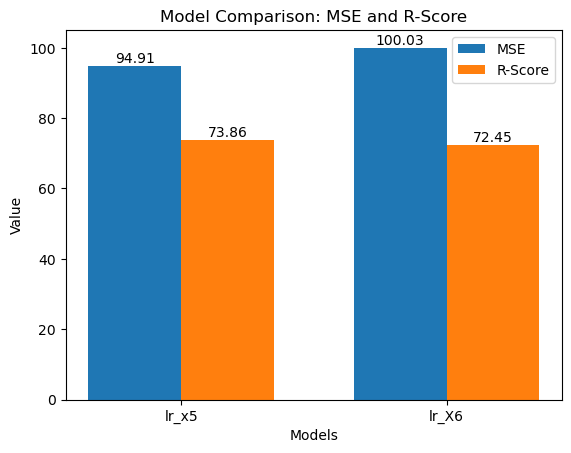

In [63]:
# The MSE and R-Score values for models lr_x5 and lr_X6
mse_lr_x5 = 94.91400862780209
mse_lr_x6 = 100.03302828033385

r_score_lr_x5 = 73.85510462979077
r_score_lr_x6 = 72.44502581056909

#The models list 
models = ['lr_x5', 'lr_X6']

# Creating an array for the x-axis positions
x = np.arange(len(models))

# Setting the width of the bars
width = 0.35

# Plotting the MSE values
mse_bars = plt.bar(x - width/2, [mse_lr_x5, mse_lr_x6], width, label='MSE')

# Plotting the R-Score values
r_score_bars = plt.bar(x + width/2, [r_score_lr_x5, r_score_lr_x6], width, label='R-Score')

# Adding value labels on the bars
for bar in mse_bars + r_score_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, '%.2f' % height, ha='center', va='bottom')

# Adding labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Value')
plt.title('Model Comparison: MSE and R-Score')
plt.xticks(x, models)
plt.legend()

# Displaying the plot
plt.show()


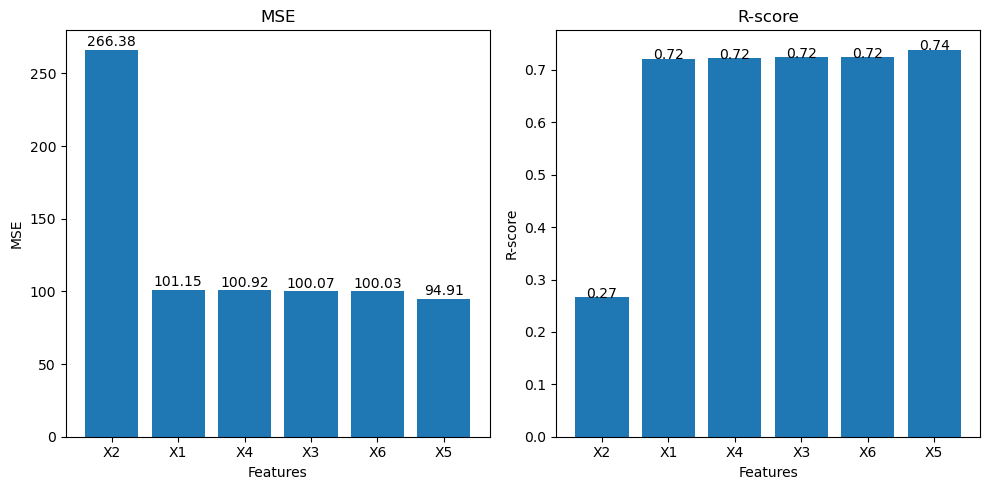

In [65]:

# MSE and R-SCores Values
mse_values = [101.14764068271944, 266.38376338320944, 100.06885474722675, 100.91778260387217, 94.91400862780209, 100.03302828033385]
rscore_values = [0.7213799605742712, 0.2662225816119911, 0.7243515709633037, 0.7220131247940047, 0.7385510462979077, 0.7244502581056909]

x_labels = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

# plot both charts in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot MSE bar chart
mse_sorted = sorted(mse_values, reverse=True)
mse_x = [x_labels[mse_values.index(val)] for val in mse_sorted]
ax1.bar(mse_x, mse_sorted)
ax1.set_title('MSE')
ax1.set_xlabel('Features')
ax1.set_ylabel('MSE')

# Display the values on the bars
for i, v in enumerate(mse_sorted):
    ax1.text(i, v + 10, str(round(v, 2)), ha='center', va='top')

# plot R-score bar chart
rscore_sorted = sorted(rscore_values)
rscore_x = [x_labels[rscore_values.index(val)] for val in rscore_sorted]
ax2.bar(rscore_x, rscore_sorted)
ax2.set_title('R-score')
ax2.set_xlabel('Features')
ax2.set_ylabel('R-score')

# Display the values on the bars
for i, v in enumerate(rscore_sorted):
    ax2.text(i, v + 0.02, str(round(v, 2)), ha='center', va='top')

# adjust layout and show plot
plt.tight_layout()
plt.show()


## 2)    Apply the principal component analysis (PCA) to reduce number of variables.

In [715]:
df_scaled

Age  DiastolicBP        BS  BodyTemp  RiskLevel
0    -0.361738     0.255023  1.905890 -0.485215   1.402991
1     0.380777     0.975539  1.298340 -0.485215   1.402991
2    -0.064732    -0.465493 -0.220537  0.973884   1.402991
3     0.009519     0.615281 -0.524312 -0.485215   1.402991
4     0.380777    -1.186009 -0.797710 -0.485215  -1.075464
...        ...          ...       ...       ...        ...
1009 -0.584493    -1.186009  1.905890 -0.485215   1.402991
1010  1.865807     0.975539  2.817216 -0.485215   1.402991
1011  0.380777    -1.186009  3.120991 -0.485215   1.402991
1012  0.974789     0.975539  2.817216 -0.485215   1.402991
1013  0.158022    -0.825751 -0.828087  1.703434   0.163764

[1014 rows x 5 columns]

### Evaluate the components:
Principal Component Analysis (PCA) is a common technique for reducing the dimensionality of data. After performing PCA, it is important to evaluate the resulting principal components to ensure that they effectively capture the variance in the data.

There are several techniques you can use to evaluate the quality of your PCA components. Here are a few:

Scree plot: A scree plot is a plot of the eigenvalues of each principal component in decreasing order. The plot can help you determine how many principal components to keep. Generally, you want to keep the principal components with eigenvalues greater than 1.

In [539]:
df_scaled

Age  DiastolicBP        BS  BodyTemp  RiskLevel
0    -0.361738     0.255023  1.905890 -0.485215   1.402991
1     0.380777     0.975539  1.298340 -0.485215   1.402991
2    -0.064732    -0.465493 -0.220537  0.973884   1.402991
3     0.009519     0.615281 -0.524312 -0.485215   1.402991
4     0.380777    -1.186009 -0.797710 -0.485215  -1.075464
...        ...          ...       ...       ...        ...
1009 -0.584493    -1.186009  1.905890 -0.485215   1.402991
1010  1.865807     0.975539  2.817216 -0.485215   1.402991
1011  0.380777    -1.186009  3.120991 -0.485215   1.402991
1012  0.974789     0.975539  2.817216 -0.485215   1.402991
1013  0.158022    -0.825751 -0.828087  1.703434   0.163764

[1014 rows x 5 columns]

## Scree plot

To determine the number of components to keep

In [641]:
df_scaled.columns

Index(['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'RiskLevel'], dtype='object')

In [644]:


# Fit PCA model and extract eigenvalues
pca = PCA()
#pca.fit(df_scaled)
pca.fit(df_scaled.drop('BodyTemp', axis= 1))
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
# Print eigenvalues and eigenvectors
print("Eigenvalues:",eigenvalues)
print()
print("\nEigenvectors:", eigenvectors)

# Plot scree plot
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()


Eigenvalues: [2.25151603 0.76351336 0.61240562 0.37651366]


Eigenvectors: [[ 0.46878336  0.47546874  0.56174695  0.48847928]
 [ 0.61332687  0.34575437 -0.21631549 -0.67638131]
 [ 0.53234389 -0.80884185  0.24954639 -0.01055698]
 [ 0.34739358 -0.01258015 -0.75853449  0.55116683]]


## Calculating the Cummulative Explained Variance to selct the best number of component. the threshold is 90%



In [69]:
# Eigenvalues
eigenvalues = np.array([2.25151603, 0.76351336, 0.61240562, 0.37651366])

# Calculate total sum of eigenvalues
total_sum = np.sum(eigenvalues)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(eigenvalues) / total_sum

# Determine the number of components for desired variance
desired_variance = 0.9  # Example: 90% desired variance
num_components = np.argmax(cumulative_variance >= desired_variance) + 1

print("Cumulative Explained Variance:", cumulative_variance)
print("Number of Components for", int(desired_variance * 100), "% Variance:", num_components)


Cumulative Explained Variance: [0.5623239  0.753014   0.90596441 1.        ]
Number of Components for 90 % Variance: 3


### Result interpretation:

The result indicates the cumulative explained variance for each component and the number of components required to capture 90% of the variance.
To capture at least 90% of the variance, we find the index of the first cumulative explained variance value that is greater than or equal to 0.9. In this case, the index is 2, which corresponds to the third component. Therefore, we need to include the first three components to capture 90% of the variance.

### PCA based on the correlated features
PCA is done based on the correlated values used for Principal component analysis

In [70]:


# fit a PCA model on the standardized data
df_ =df_scaled.drop('BodyTemp', axis= 1) 
pca_ = PCA(n_components=3) #because the first three components explains 88% of the variance
pca_.fit(df_)
# obtain the principal components
pcs_ = pca_.transform(df_)

# print the principal components
print(pcs_)

"""
Explained Variance Ratio: This metric represents the proportion of variance explained by 
each principal component. 
It can be accessed using the explained_variance_ratio_ attribute of the fitted PCA model.
"""
print("explained_variance_ratio_", pca_.explained_variance_ratio_)

"""
Cumulative Explained Variance Ratio: This metric represents the cumulative 
proportion of variance explained by the first n principal components. It can be 
useful to determine the minimum number of principal 
components required to explain a desired percentage of variance in the data.
"""
cumulative_var_ratio = np.cumsum(pca_.explained_variance_ratio_)
print("cumulative_var_ratio",cumulative_var_ratio)

"""
Reconstruction Error: This metric represents the difference between 
the original data and the reconstructed data using the selected principal components.
A lower reconstruction error indicates that the selected principal 
components are better at capturing the variability in the data.
"""
reconstructed_data = pca_.inverse_transform(pcs_)
reconstruction_error = np.mean((df_ - reconstructed_data)**2)
print("reconstruction_error",reconstruction_error)


[[ 1.70763864 -1.49491901  0.06195449]
 [ 2.05701042 -0.65897049 -0.27716748]
 [ 0.30977362 -1.10189963  0.27220499]
 ...
 [ 2.05313124 -1.80060268  1.92601853]
 [ 3.18869754 -0.6232034   0.41808132]
 [-0.70372066 -0.12022622  0.54364911]]
explained_variance_ratio_ [0.5623239  0.1906901  0.15295042]
cumulative_var_ratio [0.5623239  0.753014   0.90596441]
reconstruction_error Age            0.045394
DiastolicBP    0.000060
BS             0.216423
RiskLevel      0.114266
dtype: float64


C:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Building a linear regressionr regressionn based on the three Principal components

In [71]:

# Select the first three principal components
features_ = pcs_[:, :3]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_, y_sys, test_size=0.2, random_state=20)

# Fit a linear regression model
start_time = time.time()
model_ = LinearRegression()
model_.fit(X_train, y_train)
end_time = time.time()
# Evaluate the model
y_pred = model_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


#Calculate model complexity and execution time
execution_time = end_time - start_time

print("Mean Squared Error:", mse)
print("R-Squared Score:", r2)


print("Execution Time (in seconds):", execution_time)

Mean Squared Error: 97.05617456999417
R-Squared Score: 0.7326502625006641
Execution Time (in seconds): 0.0019936561584472656


In [72]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel', 'Age_designation'],
      dtype='object')

## Compare the performance of lr_X5 model and the model after PCA`m

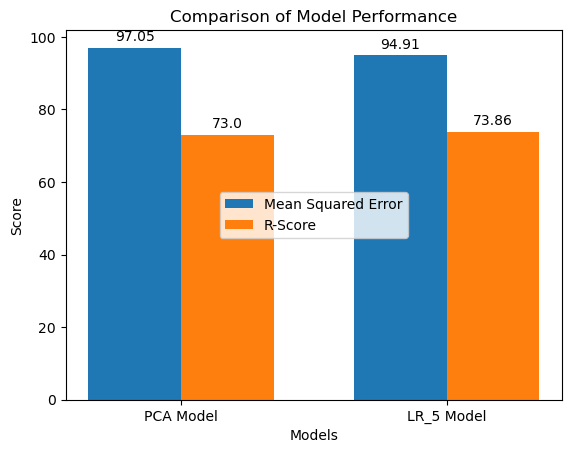

In [100]:
# Define the model names and corresponding MSE and R-Score values
models = ['PCA Model', 'LR_5 Model']
mse_values = [97.05, 94.91]
r_scores = [73, 73.86]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the x-axis ticks
r1 = np.arange(len(models))

# Create the grouped bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(r1, mse_values, width=bar_width, label='Mean Squared Error')
rects2 = ax.bar(r1 + bar_width, r_scores, width=bar_width, label='R-Score')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(r1 + bar_width / 2)
ax.set_xticklabels(models)

# Add value labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Move the legend to the center
ax.legend(loc='center')

# Show the plot
plt.show()


## 3)    Investigate the relationship between age and heartrate  by means of age grouping.

In [74]:

# Define age intervals and corresponding labels
age_intervals = [(0, 12), (13, 17), (18, 44), (45, 55), (56, 64), (65, float('inf'))]
age_labels = ['Children', 'Adolescents', 'Pre-menopausal Adults', 'Menopausal Adults', 'Post-menopausal Adults', 'Older Adults']

# Group the data based on age intervals
df['Age_group'] = pd.cut(df['Age'], bins=[interval[0]-0.1 for interval in age_intervals] + [age_intervals[-1][1]], labels=age_labels)

# Calculate mean heart rate and percentage for each age group
age_hr_df = df.groupby('Age_group').agg(mean_heart_rate=('HeartRate', 'mean'), count=('Age_group', 'count'))
age_hr_df['percentage'] = (age_hr_df['count'] / len(df)) * 100
age_hr_df['percentage'] = age_hr_df['percentage'].round(1)

# Add age intervals to the DataFrame
age_hr_df['Age_interval'] = [f"{interval[0]}-{interval[1]}" for interval in age_intervals]

# Print the results
print(age_hr_df[['Age_interval', 'mean_heart_rate', 'percentage']])


                       Age_interval  mean_heart_rate  percentage
Age_group                                                       
Children                       0-12        67.205128         3.8
Adolescents                   13-17        76.168831        15.2
Pre-menopausal Adults         18-44        74.286834        62.9
Menopausal Adults             45-55        75.746377        13.6
Post-menopausal Adults        56-64        72.325000         3.9
Older Adults                 65-inf        77.600000         0.5


ll

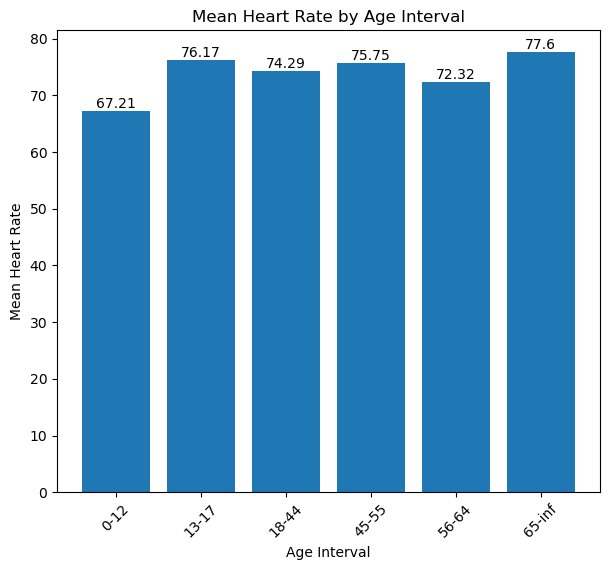

In [76]:
# Plot the mean heart rate and age interval
plt.figure(figsize=(7, 6))
bars = plt.bar(age_hr_df['Age_interval'], age_hr_df['mean_heart_rate'])

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Age Interval')
plt.ylabel('Mean Heart Rate')
plt.title('Mean Heart Rate by Age Interval')
plt.xticks(rotation=45)
plt.show()


## 4)    Describe how would you investigate associations between pairs high/high, normal/normal, and low/low diastolic and systolic blood pressure.  
Calculate, and interpret the following:

In [102]:

# Load data into arrays
systolic_bp = df["SystolicBP"]
diastolic_bp = df["DiastolicBP"]

# Calculate correlation coefficient
corr_coef = np.corrcoef(systolic_bp, diastolic_bp)[0, 1]

print('Correlation coefficient:', corr_coef)


Correlation coefficient: 0.7870064769775301


### Calculate, and interpret the following:
(1)    Support

We need to encode our data before calculating support because most algorithms for association rule mining work with binary data, i.e., they require input data in a transactional format, where each transaction represents a set of items that are present in that transaction.

In order to use association rule mining algorithms, we need to encode the original data such that each row represents a transaction and each column represents a unique item in the data set. The values in each cell can be binary (1/0) representing the presence or absence of the item in the transaction.

Encoding the data in this way is necessary for calculating support because support is defined as the proportion of transactions that contain a particular itemset. Without encoding, it would be difficult to determine the frequency of each itemset in the data.

Additionally, encoding allows us to reduce the size of the data set by eliminating duplicates and grouping transactions that have the same set of items. This can make the data more manageable for analysis and reduce the computational requirements of the algorithms.

In [103]:
!pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [104]:


# binarize data
te = TransactionEncoder()
te_data = te.fit_transform(df.drop(columns=['RiskLevel']))
data = pd.DataFrame(te_data, columns=te.columns_)

# calculate support
support = apriori(data, min_support=0.2, use_colnames=True)
print(support)


Empty DataFrame
Columns: [support, itemsets]
Index: []


In [105]:
df2 = df.copy()

In [106]:
### define the categories of blood pressure
high_high_df2 = df2[(df2['SystolicBP'] > 140) & (df2['DiastolicBP'] > 90)]
normal_normal_df2 = df2[(df2['SystolicBP'].between(110, 140)) & (df2['DiastolicBP'].between(70, 90))]
low_low_df2 = df2[(df2['SystolicBP'] < 110) & (df2['DiastolicBP'] < 70)]

## Find the mean
high_high_mean = high_high_df2['SystolicBP'].mean()
normal_normal_mean = normal_normal_df2['SystolicBP'].mean()
low_low_mean = low_low_df2['SystolicBP'].mean()

# Step 3: Visualize the subsets (example: histogram)


plt.hist(high_high_df2['SystolicBP'], bins=10, label='High/High')
plt.hist(normal_normal_df2['SystolicBP'], bins=10, label='Normal/Normal')
plt.hist(low_low_df2['SystolicBP'], bins=10, label='Low/Low')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [107]:
# Create the systolic category coulmn
df2['SystolicCategory'] = pd.NA
df2.loc[df2['SystolicBP'] >= 140, 'SystolicCategory'] = 'High'
df2.loc[(df2['SystolicBP'] >= 110) & (df2['SystolicBP'] < 140), 'SystolicCategory'] = 'Normal'
df2.loc[df2['SystolicBP'] < 110, 'SystolicCategory'] = 'Low'

# Create the diastolic category coulmn
df2['DiastolicCategory'] = pd.NA
df2.loc[df2['DiastolicBP'] >= 90, 'DiastolicCategory'] = 'High'
df2.loc[(df2['DiastolicBP'] >= 70) & (df2['DiastolicBP'] < 90), 'DiastolicCategory'] = 'Normal'
df2.loc[df2['DiastolicBP'] < 70, 'DiastolicCategory'] = 'Low'

Blood pressure is recorded with 2 numbers: the systolic pressure and diastolic blood pressure. Assume, the high systolic blood pressure starts from 140, the high diastolic blood pressure starts from 90. The normal systolic pressure is in the range (110, 140). The normal diastolic blood pressure is in the range (70, 90). The low systolic pressure is lower than 110, and low diastolic is less than 70.

Describe how would you investigate associations between pairs high/high, normal/normal, and low/low diastolic and systolic blood pressure.  
Calculate, and interpret the following:
(1)    Support
(2)    Confidence
(3)    Conviction
(4)    Lift

In [108]:
df2

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0      25         130           80  15.0      98.0         86          3   
1      35         140           90  13.0      98.0         70          3   
2      29          90           70   8.0     100.0         80          3   
3      30         140           85   7.0      98.0         70          3   
4      35         120           60   6.1      98.0         76          1   
...   ...         ...          ...   ...       ...        ...        ...   
1009   22         120           60  15.0      98.0         80          3   
1010   55         120           90  18.0      98.0         60          3   
1011   35          85           60  19.0      98.0         86          3   
1012   43         120           90  18.0      98.0         70          3   
1013   32         120           65   6.0     101.0         76          2   

            Age_designation              Age_group AgeGroup SystolicCategory  \
0     Pre-menopausal Adults  Pre-menopausal Adults  Group 1           Normal   
1     Pre-menopausal Adults  Pre-menopausal Adults  Group 2             High   
2     Pre-menopausal Adults  Pre-menopausal Adults  Group 1              Low   
3     Pre-menopausal Adults  Pre-menopausal Adults  Group 1             High   
4     Pre-menopausal Adults  Pre-menopausal Adults  Group 2           Normal   
...                     ...                    ...      ...              ...   
1009  Pre-menopausal Adults  Pre-menopausal Adults  Group 1           Normal   
1010      Menopausal Adults      Menopausal Adults  Group 4           Normal   
1011  Pre-menopausal Adults  Pre-menopausal Adults  Group 2              Low   
1012  Pre-menopausal Adults  Pre-menopausal Adults  Group 3           Normal   
1013  Pre-menopausal Adults  Pre-menopausal Adults  Group 2           Normal   

     DiastolicCategory  
0               Normal  
1                 High  
2               Normal  
3               Normal  
4                  Low  
...                ...  
1009               Low  
1010              High  
1011               Low  
1012              High  
1013               Low  

[1014 rows x 12 columns]

### Encoding the Blood Pressure Categories

In [109]:
#Subset df2 to only seelect the blood pressure categories
df3 = df2[['SystolicCategory','DiastolicCategory']]
df3.sample(3)

SystolicCategory DiastolicCategory
53            Normal            Normal
704              Low               Low
86            Normal            Normal

In [110]:
# Perform one-hot encoding for 'SystolicCategory' and 'DiastolicCategory'
df_encoded = pd.get_dummies(df3, columns=['SystolicCategory', 'DiastolicCategory'])

# Print the encoded DataFrame
df_encoded


SystolicCategory_High  SystolicCategory_Low  SystolicCategory_Normal  \
0                         0                     0                        1   
1                         1                     0                        0   
2                         0                     1                        0   
3                         1                     0                        0   
4                         0                     0                        1   
...                     ...                   ...                      ...   
1009                      0                     0                        1   
1010                      0                     0                        1   
1011                      0                     1                        0   
1012                      0                     0                        1   
1013                      0                     0                        1   

      DiastolicCategory_High  DiastolicCategory_Low  DiastolicCategory_Normal  
0                          0                      0                         1  
1                          1                      0                         0  
2                          0                      0                         1  
3                          0                      0                         1  
4                          0                      1                         0  
...                      ...                    ...                       ...  
1009                       0                      1                         0  
1010                       1                      0                         0  
1011                       0                      1                         0  
1012                       1                      0                         0  
1013                       0                      1                         0  

[1014 rows x 6 columns]

### Supports

In [111]:
# Calculate supports for the three c
support_high_high = len(df_encoded[(df_encoded['SystolicCategory_High'] == 1) & (df_encoded['DiastolicCategory_High'] == 1)]) / len(df_encoded)
support_normal_normal = len(df_encoded[(df_encoded['SystolicCategory_Normal'] == 1) & (df_encoded['DiastolicCategory_Normal'] == 1)]) / len(df_encoded)
support_low_low = len(df_encoded[(df_encoded['SystolicCategory_Low'] == 1) & (df_encoded['DiastolicCategory_Low'] == 1)]) / len(df_encoded)

print("Support for High/High: ", support_high_high)
print("Support for Normal/Normal: ", support_normal_normal)
print("Support for Low/Low: ", support_low_low)


Support for High/High:  0.11538461538461539
Support for Normal/Normal:  0.33530571992110453
Support for Low/Low:  0.26627218934911245


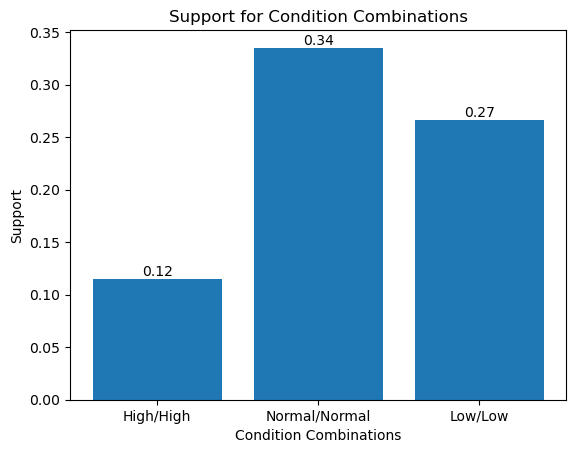

In [112]:
# Define the support values
support_values = [0.11538461538461539, 0.33530571992110453, 0.26627218934911245]
labels = ['High/High', 'Normal/Normal', 'Low/Low']

# Create the bar chart
plt.bar(labels, support_values)
plt.xlabel('Condition Combinations')
plt.ylabel('Support')
plt.title('Support for Condition Combinations')

# Add values on the bars
for i, v in enumerate(support_values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Display the chart
plt.show()


###  Confidence


In [113]:
# Calculate confidence for High/High
confidence_high_high = len(df_encoded[(df_encoded['SystolicCategory_High'] == 1) & (df_encoded['DiastolicCategory_High'] == 1)]) / len(df_encoded[df_encoded['SystolicCategory_High'] == 1])

# Calculate confidence for Normal/Normal
confidence_normal_normal = len(df_encoded[(df_encoded['SystolicCategory_Normal'] == 1) & (df_encoded['DiastolicCategory_Normal'] == 1)]) / len(df_encoded[df_encoded['SystolicCategory_Normal'] == 1])

# Calculate confidence for Low/Low
confidence_low_low = len(df_encoded[(df_encoded['SystolicCategory_Low'] == 1) & (df_encoded['DiastolicCategory_Low'] == 1)]) / len(df_encoded[df_encoded['SystolicCategory_Low'] == 1])
print("Confidence for High/High: ", confidence_high_high)
print("Confidence for Normal/Normal: ", confidence_normal_normal)
print("Confidence for Low/Low: ", confidence_low_low)


Confidence for High/High:  0.9
Confidence for Normal/Normal:  0.6296296296296297
Confidence for Low/Low:  0.7848837209302325


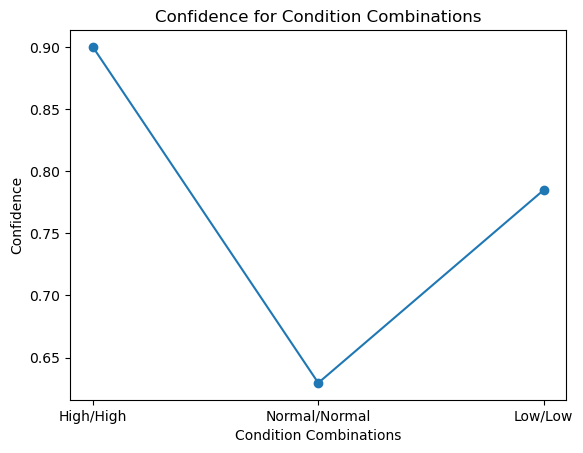

In [114]:

# Define the confidence values
confidence_values = [0.9, 0.6296296296296297, 0.7848837209302325]
labels = ['High/High', 'Normal/Normal', 'Low/Low']

# Create the line plot
plt.plot(labels, confidence_values, marker='o')
plt.xlabel('Condition Combinations')
plt.ylabel('Confidence')
plt.title('Confidence for Condition Combinations')

# Display the plot
plt.show()


### Conviction

In [115]:
# Calculate conviction for High/Not High
conviction_high_not_high = (1 - support_high_high) / (1 - confidence_high_high)

# Calculate conviction for Normal/Not Normal
conviction_normal_not_normal = (1 - support_normal_normal) / (1 - confidence_normal_normal)

# Calculate conviction for Low/Not Low
conviction_low_not_low = (1 - support_low_low) / (1 - confidence_low_low)

print("Conviction for High/Not High: ", conviction_high_not_high)
print("Conviction for Normal/Not Normal: ", conviction_normal_not_normal)
print("Conviction for Low/Not Low: ", conviction_low_not_low)


Conviction for High/Not High:  8.846153846153848
Conviction for Normal/Not Normal:  1.794674556213018
Conviction for Low/Not Low:  3.410842795458179


In [134]:
# Calculate conviction for High systolic and high diastolic
conviction_high_high = (1 - support_high_high) / (1 - confidence_high_high)

print("Conviction for High systolic and high diastolic: ", conviction_high_high)

# Calculate conviction for Normal systolic and Normal diastolic
conviction_normal_normal = (1 - support_normal_normal) / (1 - confidence_normal_normal)

# Calculate conviction for Low systolic and Low diastolic
conviction_low_low = (1 - support_low_low) / (1 - confidence_low_low)


print("Conviction for Normal systolic and Normal diastolic: ", conviction_normal_normal)
print("Conviction for Low systolic and Low diastolic: ", conviction_low_low)


Conviction for High systolic and high diastolic:  8.846153846153848
Conviction for Normal systolic and Normal diastolic:  1.794674556213018
Conviction for Low systolic and Low diastolic:  3.410842795458179


### Lift

In [ ]:
support_high = len(df_encoded[df_encoded['SystolicCategory_High'] == 1]) / len(df_encoded)
support_normal = len(df_encoded[df_encoded['SystolicCategory_Normal'] == 1]) / len(df_encoded)
support_low = len(df_encoded[df_encoded['SystolicCategory_Low'] == 1]) / len(df_encoded)

# Calculate lift for High/High
lift_high_high = support_high_high / (support_high * support_high)

# Calculate lift for Normal/Normal
lift_normal_normal = support_normal_normal / (support_normal * support_normal)

# Calculate lift for Low/Low
lift_low_low = support_low_low / (support_low * support_low)


print("Lift for High/High: ", lift_high_high)
print("Lift for Normal/Normal: ", lift_normal_normal)
print("Lift for Low/Low: ", lift_low_low)


In [ ]:

# Define the conviction values and corresponding labels
conviction_values = [8.846153846153848, 1.794674556213018, 3.410842795458179]
labels = ['High/Not High', 'Normal/Not Normal', 'Low/Not Low']

# Create the bar chart
plt.bar(labels, conviction_values)
plt.xlabel('Condition Combinations')
plt.ylabel('Conviction')
plt.title('Conviction for Condition Combinations')

# Add the values to the bars
for i, v in enumerate(conviction_values):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Display the chart
plt.show()


In [ ]:

# Define the lift values
lift_values = [7.02, 1.182304526748971, 2.3135816657652786]
labels = ['High/High', 'Normal/Normal', 'Low/Low']

# Create the bar chart
plt.bar(labels, lift_values)
plt.xlabel('Condition Combinations')
plt.ylabel('Lift')
plt.title('Lift for Condition Combinations')

# Add values to the bars
for i, v in enumerate(lift_values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Display the chart
plt.show()


In [117]:
df

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0      25         130           80  15.0      98.0         86          3   
1      35         140           90  13.0      98.0         70          3   
2      29          90           70   8.0     100.0         80          3   
3      30         140           85   7.0      98.0         70          3   
4      35         120           60   6.1      98.0         76          1   
...   ...         ...          ...   ...       ...        ...        ...   
1009   22         120           60  15.0      98.0         80          3   
1010   55         120           90  18.0      98.0         60          3   
1011   35          85           60  19.0      98.0         86          3   
1012   43         120           90  18.0      98.0         70          3   
1013   32         120           65   6.0     101.0         76          2   

            Age_designation              Age_group AgeGroup  
0     Pre-menopausal Adults  Pre-menopausal Adults  Group 1  
1     Pre-menopausal Adults  Pre-menopausal Adults  Group 2  
2     Pre-menopausal Adults  Pre-menopausal Adults  Group 1  
3     Pre-menopausal Adults  Pre-menopausal Adults  Group 1  
4     Pre-menopausal Adults  Pre-menopausal Adults  Group 2  
...                     ...                    ...      ...  
1009  Pre-menopausal Adults  Pre-menopausal Adults  Group 1  
1010      Menopausal Adults      Menopausal Adults  Group 4  
1011  Pre-menopausal Adults  Pre-menopausal Adults  Group 2  
1012  Pre-menopausal Adults  Pre-menopausal Adults  Group 3  
1013  Pre-menopausal Adults  Pre-menopausal Adults  Group 2  

[1014 rows x 10 columns]

In [118]:
df_scaled

Age  DiastolicBP        BS  BodyTemp  RiskLevel
0    -0.361738     0.255023  1.905890 -0.485215   1.402991
1     0.380777     0.975539  1.298340 -0.485215   1.402991
2    -0.064732    -0.465493 -0.220537  0.973884   1.402991
3     0.009519     0.615281 -0.524312 -0.485215   1.402991
4     0.380777    -1.186009 -0.797710 -0.485215  -1.075464
...        ...          ...       ...       ...        ...
1009 -0.584493    -1.186009  1.905890 -0.485215   1.402991
1010  1.865807     0.975539  2.817216 -0.485215   1.402991
1011  0.380777    -1.186009  3.120991 -0.485215   1.402991
1012  0.974789     0.975539  2.817216 -0.485215   1.402991
1013  0.158022    -0.825751 -0.828087  1.703434   0.163764

[1014 rows x 5 columns]

##  5) Find clusters of patients with similar Systolic BP.

## Elbow plot to choose the optimum clusyter
The elbow plot shows the inertia (sum of squared distances) on the y-axis and the number of clusters on the x-axis. The optimal number of clusters is typically chosen at the "elbow" of the plot, which is the point where adding more clusters starts to result in diminishing returns in terms of reducing inertia.

To determine the best value from the elbow plot, look for the point where the inertia values start to level off or decrease less steeply. This indicates the point of diminishing returns, and choosing the number of clusters at or near this point can be a reasonable selection.

Note that the optimal number of clusters is subjective and depends on the specific problem and dataset. The elbow plot provides a visual aid in making an informed decision, but other factors such as domain knowledge and practical considerations should also be taken into account.

In [125]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel', 'Age_designation', 'Age_group', 'AgeGroup', 'ClusterLabel',
       'ClusterCenter'],
      dtype='object')

## Scale all the features to form clusters

In [126]:
df_scaled.sample(3)

Age  DiastolicBP        BS  BodyTemp  RiskLevel
509 -0.955750    -1.186009 -0.372424  1.703434  -1.075464
589 -0.732996     0.975539 -0.372424 -0.485215   0.163764
27  -0.584493    -0.825751 -0.463557 -0.485215  -1.075464

# Question 5:  Clustring 

### Feature importance
Feature importance is calcuated to determine the number of featres to keep based on their importance

In [135]:
data = df_scaled

# Split the data into features and target variable
X = data
y = y_sys

# Initialize the ExtraTreesClassifier
model = ExtraTreesClassifier()

# Fitting the model to the data
model.fit(X, y)

# Getting the feature importances
importance_scores = model.feature_importances_

# Print the feature importances
for feature, score in zip(X.columns, importance_scores):
    print(f"{feature}: {score}")


Age: 0.250842938229554
DiastolicBP: 0.3895976360438303
BS: 0.2033922897066136
BodyTemp: 0.06289733985186981
RiskLevel: 0.09326979616813227


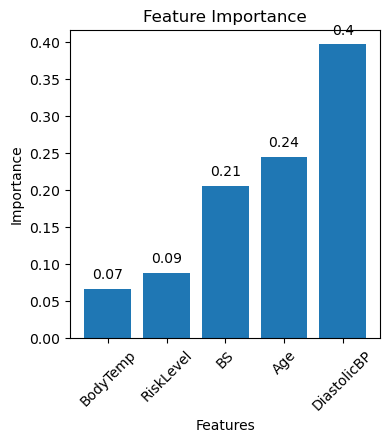

In [128]:
# Definng the feature names and their corresponding importance values
features = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'RiskLevel']
importance = [0.24427113954626206, 0.39688640253743357, 0.2050734491287369, 0.06626901297330891, 0.08749999581425863]

# Sorting the features and importance values in ascending order
sorted_indices = sorted(range(len(importance)), key=lambda k: importance[k])
sorted_features = [features[i] for i in sorted_indices]
sorted_importance = [importance[i] for i in sorted_indices]

# Ploting the sorted feature importance values with labels
plt.figure(figsize=(4, 4))
plt.bar(sorted_features, sorted_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Adding value labels on the bars
for i, v in enumerate(sorted_importance):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()


### Finding the optimal number of clusters:
using the silhuette scores between 2 and 1 clusters to determine the best number of cluster.

###### 1: Silhouette scores

[0.45197110328266493, 0.45214733638762195, 0.43153060481195005, 0.4128136990505607, 0.4075705497797439, 0.20017767271784714, 0.25759599340071543, 0.27300713124115344, 0.09837728144753262]


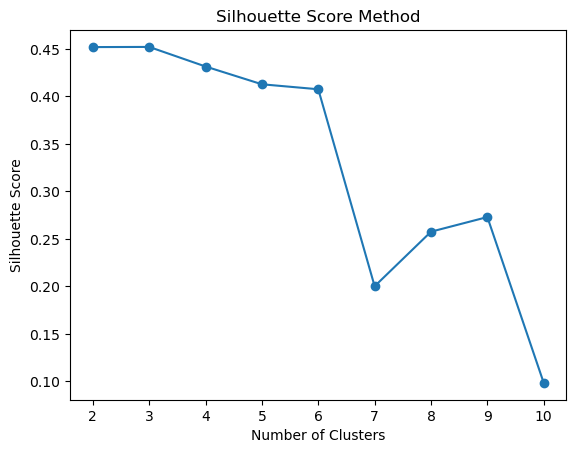

In [129]:
# Select the relevant features for clustering
data = df_scaled[['Age', 'DiastolicBP']]

# Initialize the list to store the silhouette scores
silhouette_scores = []

# Try different numbers of clusters
for n_clusters in range(2, 11):
    gmn = GaussianMixture(n_components=n_clusters)
    gmn.fit(data)
    labels = gmn.predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Plot the number of clusters vs silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
print(silhouette_scores)

plt.show()


The silhouette score is a measure of how well each sample in a cluster is assigned to the cluster compared to other clusters. It ranges from -1 to 1, where a higher score indicates better clustering results. Here's how to interpret the silhouette scores:

If the silhouette score is close to 1, it means that the samples are well-clustered, with a good separation between clusters.
If the silhouette score is close to 0, it suggests overlapping clusters or that the sample could be assigned to multiple clusters.
If the silhouette score is close to -1, it indicates that the samples may have been assigned to the wrong clusters.
Based on the provided silhouette scores:
[0.4847692615256214, 0.5334814657049258, 0.4362145946416666, 0.4598441556913825, 0.4160887046759709, 0.4481915749775673, 0.48705510833640736, 0.47511614397896623, 0.39825969176227094]

The second score (0.5335) is the highest among all the scores, indicating that it has the best clustering result. Therefore, based on the silhouette scores, the optimal number of clusters would be 3.

### Trying elebow plot to determine the number of clusters
The elboe plot also suggest around 3 clusters

In [136]:
# Initialize an empty list to store the inertia values
inertia = []

# Define a range of cluster numbers to try
max_clusters = 10  # Maximum number of clusters to consider

for num_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\clust

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


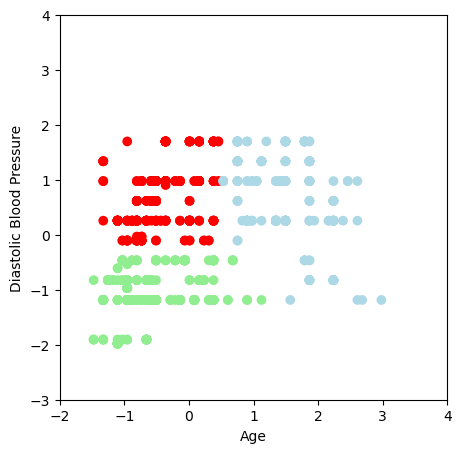

In [130]:


# Select the relevant features for clustering
data = df_scaled[['Age', 'DiastolicBP']]

# Fit K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
labels = kmeans.labels_

# Define colors based on cluster labels
colors = ['red' if l==0 else 'lightblue' if l==1 else 'lightgreen' if l==2 else 'pink' if l==3 else 'darkblue' if l==4 else 'darkgreen' if l==5 else 'magenta' if l==6 else 'orange' if l==7 else 'darkred' if l==8 else 'yellow' for l in labels]

# Create scatter plot
fig = plt.figure(figsize=(5, 5))
plt.scatter(data['Age'], data['DiastolicBP'], c=colors)
plt.xlabel('Age')
plt.ylabel('Diastolic Blood Pressure')
plt.xlim(-2, 4)
plt.ylim(-3, 4)
plt.show()


#### Evaluation Metics
### 1: Internal
calculate the Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index:

In [131]:

# Assuming 'data' contains your clustered data

# Silhouette Score
silhouette_avg = silhouette_score(data, labels)

# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(data, labels)

# Davies-Bouldin Index
db_score = davies_bouldin_score(data, labels)

print("Silhouette Score:", silhouette_avg)
print("Calinski-Harabasz Index:", ch_score)
print("Davies-Bouldin Index:", db_score)


Silhouette Score: 0.46462512501559866
Calinski-Harabasz Index: 1211.8190983999086
Davies-Bouldin Index: 0.7625541669526118


##### External Evaluation Metrics
### 2: External

In [132]:

# Assuming you have the actual labels in the 'actual_labels' variable
actual_labels = y_sys

# Assuming you have the predicted labels from clustering in the 'predicted_labels' variable
predicted_labels =labels

# Calculate Adjusted Rand Index (ARI)
ari = metrics.adjusted_rand_score(actual_labels, predicted_labels)

# Calculate Normalized Mutual Information (NMI)
nmi = metrics.normalized_mutual_info_score(actual_labels, predicted_labels)

# Calculate Fowlkes-Mallows Index (FMI)
fmi = metrics.fowlkes_mallows_score(actual_labels, predicted_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("FMI:", fmi)


ARI: 0.18958684414161484
NMI: 0.2794642837947549
FMI: 0.42806528184911496


# Question (6)    Calculate the correlation between age and systolic BP. Interpret your result.
There is a correlation coefficient of 0.416 which suggests a moderate positive linear relationship between age and systolic blood pressure in the context of maternal health so as the age of women in the population increases, there is a tendency for their systolic blood pressure levels to also increase.

In [133]:
# calculate the correlation 
correlation = df['Age'].corr(df['SystolicBP'])
print(f"Correlation between Age and SystolicBP: {correlation}")


Correlation between Age and SystolicBP: 0.4160454479747331
